In [1]:
%load_ext cmdstanjupyter

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import linalg
from scipy import special
import matplotlib.pyplot as plt
import arviz as ar

In [3]:
def generate_mix(n):
    out = []
    for i in range(n):
        u = np.random.uniform()
        if u < 1/6:
            out = out + [np.random.beta(5, 45)]
        elif 1/6 <= u < 1/2:
            out = out + [np.random.beta(25, 25)]
        else:
            out = out + [np.random.beta(45, 5)]
    return np.array(out)

(array([14.,  1.,  0.,  7., 21.,  9.,  0.,  0., 13., 35.]),
 array([0.07283768, 0.16246525, 0.25209283, 0.3417204 , 0.43134797,
        0.52097555, 0.61060312, 0.70023069, 0.78985826, 0.87948584,
        0.96911341]),
 <BarContainer object of 10 artists>)

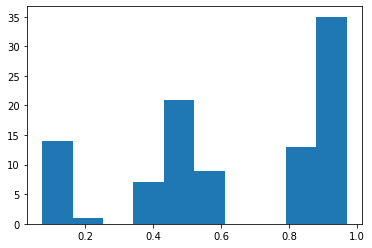

In [5]:
Y = generate_mix(100)
plt.hist(Y)

In [3]:
# function to create cell_count values m_h from H, where H is a numpy array of non-negative integers 
# and there are N possible values
# output is count vector of size equal to the number of unique entries in H 
def m_count(H, N):
    out = []
    for h in range(N):
        out = out + [len(H) - np.count_nonzero(H - h)]
    return np.array(out)

In [4]:
# creating one array frowm two arrays by merging based on an indicator vector of 0's and 1's
# e.g. given ind_vec = (0, 1, 1, 0, 0, 1), arr0 = (a, b, c) and arr1 = (x, y, z), we have: out = (a, x, y, b, c, z)
# must have: len(arr0) + len(arr1) = len(ind_vec)
def ind_merge(ind_vec, list0, list1):
    if len(list0) + len(list1) != len(ind_vec):
        raise ValueError(" Must have: len(arr1) + len(arr2) = len(ind_vec) !! ")
    a0 = list0.copy()
    a1 = list1.copy()
    n = len(ind_vec)
    out = [None]*n
    for j in range(n):
        if ind_vec[j] == 0:
          out[j] = a0[0]
          a0.pop(0)
        else:
          out[j] = a1[0]
          a1.pop(0)
    return out

In [5]:
%%stan alpha_model
data{
    int N;
    vector[N] W;
}

parameters{
    real<lower=0> alpha;
}

model{
    alpha ~ exponential(1);
    W ~ dirichlet(rep_vector(alpha/N, N));
}

INFO:cmdstanjupyter:Reusing cached model file .stan/alpha_model.stan
INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "alpha_model"
INFO:cmdstanjupyter:StanModel now available as variable "alpha_model"!
 Compilation took a moment.


In [6]:
def update_alpha(W, N):
    # data to be fed to STAN
    data_alpha = {'N':N, 'W':W}

    # building STAN model and drawing samples
    fit_alpha = alpha_model.sample(data = data_alpha)

    # returning output
    return fit_alpha.summary()['Mean'].iloc[1]

In [7]:
def update_W(alpha, H, N):
    m_vec = m_count(H, N)
    return np.ravel(np.random.dirichlet(np.array([alpha/N + m for m in m_vec]), size = 1))

In [8]:
def update_H(W, Theta, Y, N, nu_0):
    n = len(Y)
    H = -np.ones(n)
    for i in range(n):
        p_vec = np.array([W[h]*stats.beta.pdf(Y[i], a = Theta[h]*nu_0, b = (1 - Theta[h])*nu_0) for h in range(N)])
        p_vec = p_vec/sum(p_vec)
        H[i] = np.array([list(v).index(1) for v in np.random.multinomial(n = 1, pvals = p_vec, size = 1)])
    return np.int_(H)

In [9]:
def create_Y_H(Y, H):
    active_list = list(frozenset(H))
    N_0 = len(active_list)
    Y_H = [None]*N_0
    df1 = pd.DataFrame.copy(pd.DataFrame(Y), deep = True) # pass by value (not reference) so that original df_bar stays intact
    df1['H'] = H
    df2 = df1.groupby('H')
    for k in range(N_0):
        out_temp = df2.get_group(active_list[k]).drop('H', axis = 1, inplace = False)
        Y_H[k] = np.array(out_temp).ravel()
    return Y_H

In [10]:
%%stan Theta_model
data {
    int<lower = 0> n;
    real<lower=0> nu_0;
    vector<lower=0, upper=1>[n] Y;
}

parameters {
    real<lower=0, upper = 1> theta;
}

model {
    theta ~ uniform(0, 1);
    for(i in 1:n) {
      Y[i] ~ beta(theta*nu_0, (1 - theta)*nu_0);
    }
}

INFO:cmdstanjupyter:Reusing cached model file .stan/Theta_model.stan
INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "Theta_model"
INFO:cmdstanjupyter:StanModel now available as variable "Theta_model"!
 Compilation took a moment.


In [11]:
# wrapper definition for theta updates
def update_Theta(Y, H, N, nu_0):
    # out1 stores just the active theta values
    active_list = list(frozenset(H))
    out1 = []
    Y_H = create_Y_H(Y, H)

    # creating separate data feeds and draws df for each of the active theta's
    for l in Y_H:
        data_Theta = {'n':len(l), 'nu_0':nu_0, 'Y':l}
        fit_Theta = Theta_model.sample(data = data_Theta)
        out1 = out1 + list(fit_Theta.summary()['Mean'].iloc[1:])

    if len(active_list) == N:
        return np.array(out1) 
    else:
        out2 = list(np.random.uniform(size = N - len(active_list)))
        out = ind_merge([int(v in active_list) for v in range(N)], out2, out1)
    return out

In [13]:
def update_all(n_iter, Y, N, nu_0):
    n = len(Y)
  
    # initializing (randomly) array for the indexing variable H_i, i = 0, ... n - 1
    H = np.array([list(v).index(1) for v in np.random.multinomial(n = 1, pvals = np.ones(N)/N, size = n)])
    print(len(H))

    # initializing (randomly) array for the base measure variable theta_h, h = 0, ... N - 1
    Theta = np.random.uniform(size = N)

    # initializing array for Dirichlet component weight variable w_h, h = 0, ... N - 1
    W = np.ones(N)/N

    # initializing scale variable alpha
    alpha = 1

    # loop
    alpha_mat = []
    W_mat = []
    Theta_mat = []
    H_mat = []
    for j in range(n_iter):
        alpha = update_alpha(W, N)
        W = update_W(alpha, H, N)
        Theta = update_Theta(Y, H, N, nu_0)
        H = update_H(W, Theta, Y, N, nu_0)

        # storing all draws
        alpha_mat = alpha_mat + [alpha]
        Theta_mat = Theta_mat + [Theta]
        H_mat = H_mat + [H]
        W_mat = W_mat + [W]

    return {'alpha':alpha, 'W':W, 'Theta':Theta, 'H':H, 'alpha_mat':alpha_mat, 
          'Theta_mat':Theta_mat, 'H_mat':H_mat, 'W_mat':W_mat}

In [14]:
den_full = update_all(n_iter = 100, Y = Y, N = 5, nu_0 = 100)

NameError: name 'Y' is not defined

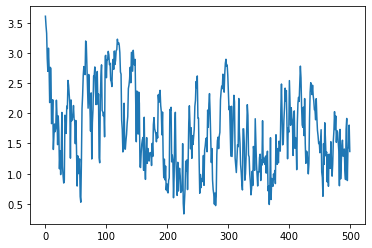

In [53]:
# alpha convergence plot
plt.plot(den_full['alpha_mat'])

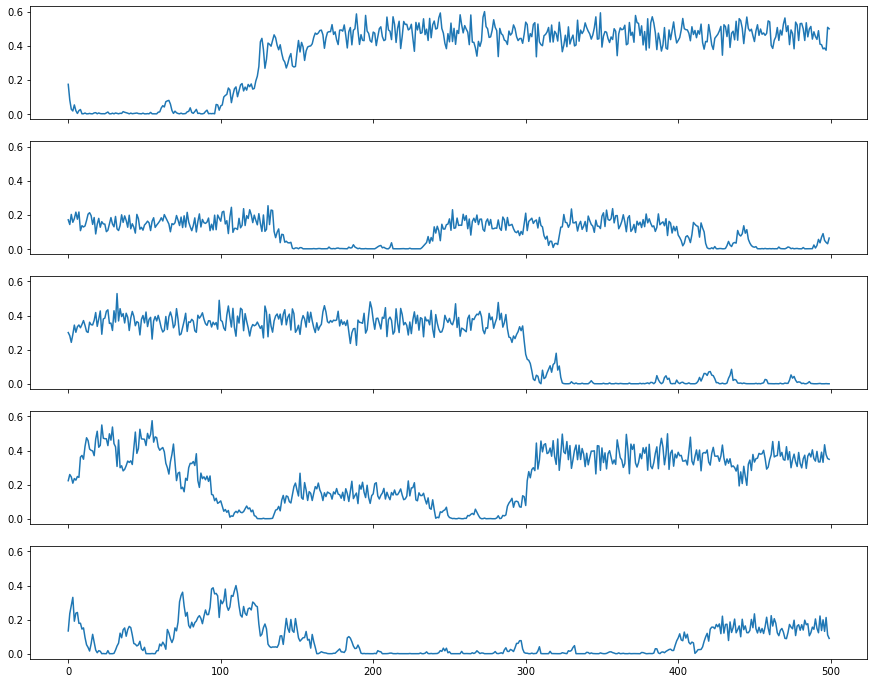

In [54]:
fig, axes = plt.subplots(nrows = 5, ncols = 1, sharex = True, sharey = True, squeeze=True, subplot_kw=None, figsize=(15, 12))
for h in range(N):
    axes[h].plot(np.array(den_full['W_mat']).T[h])
plt.show()

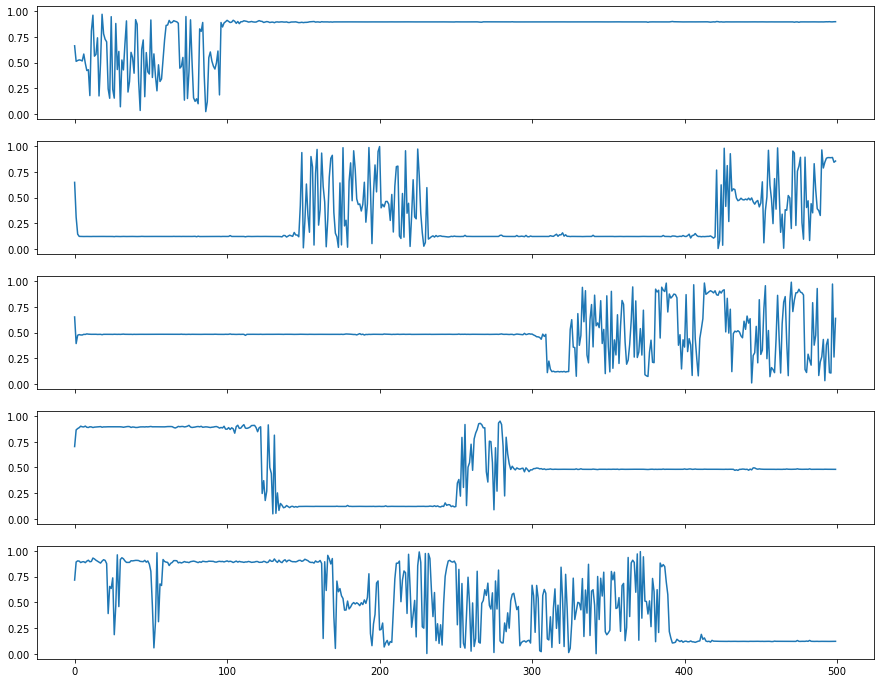

In [55]:
fig, axes = plt.subplots(nrows = 5, ncols = 1, sharex = True, sharey = True, squeeze=True, subplot_kw=None, figsize=(15, 12))
for h in range(N):
    axes[h].plot(np.array(den_full['Theta_mat']).T[h])
plt.show()

In [20]:
# param_mat is a matrix of parameters, each row is an array of format: [a, b], the shape parameters of beta
def pdf_mix_beta(param_mat, weights, grid_size):
    grid = np.linspace(0, 1, grid_size)
    N = len(weights)
    def mix(x):
        return sum([weights[h]*stats.beta.pdf(x, a = param_mat[h][0], b = param_mat[h][1]) for h in range(N)])
    return mix(grid)

(array([1.56201931, 0.11157281, 0.        , 0.78100966, 2.34302897,
        1.00415527, 0.        , 0.        , 1.4504465 , 3.90504828]),
 array([0.07283768, 0.16246525, 0.25209283, 0.3417204 , 0.43134797,
        0.52097555, 0.61060312, 0.70023069, 0.78985826, 0.87948584,
        0.96911341]),
 <BarContainer object of 10 artists>)

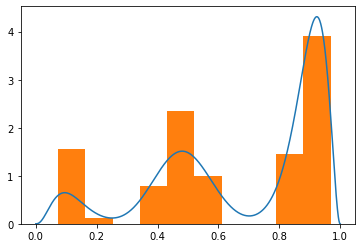

In [57]:
# checking if the posterior density matches the original histogram of Y
plt.plot(np.linspace(0, 1, 1000), pdf_mix_beta(param_mat = [[v*nu_0, (1 - v)*nu_0] for v in den_full['Theta']], 
                      weights = den_full['W'], grid_size = 1000))
plt.hist(Y, density = True)

# Testing with F(x) = $1 - (x - 1)^2$

In [15]:
def F_inv(U):
    return 1 - np.sqrt(1 - U)

(array([3.67486106, 2.48301423, 1.86226067, 1.56429897, 1.19184683,
        0.69524398, 0.44694256, 0.24830142, 0.173811  , 0.07449043]),
 array([5.05753446e-04, 8.10530163e-02, 1.61600279e-01, 2.42147542e-01,
        3.22694805e-01, 4.03242068e-01, 4.83789331e-01, 5.64336594e-01,
        6.44883857e-01, 7.25431120e-01, 8.05978382e-01]),
 <BarContainer object of 10 artists>)

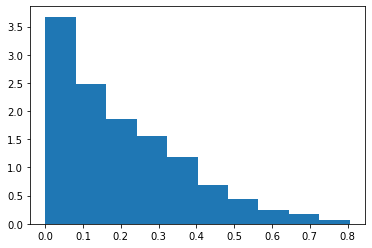

In [16]:
Y_new = np.array([1 - (1 - U)**0.25 for U in np.random.uniform(size = 500)])
plt.hist(Y_new, density = True)

In [18]:
full_new = update_all(n_iter = 100, Y = Y_new, N = 5, nu_0 = 20)

18:16:07 - cmdstanpy - INFO - CmdStan start processing


500


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:07 - cmdstanpy - INFO - CmdStan done processing.


18:16:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:08 - cmdstanpy - INFO - CmdStan done processing.
18:16:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:16:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:09 - cmdstanpy - INFO - CmdStan done processing.
18:16:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:16:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:09 - cmdstanpy - INFO - CmdStan done processing.
18:16:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:16:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:10 - cmdstanpy - INFO - CmdStan done processing.
18:16:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:16:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:11 - cmdstanpy - INFO - CmdStan done processing.
18:16:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:16:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:12 - cmdstanpy - INFO - CmdStan done processing.


18:16:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:13 - cmdstanpy - INFO - CmdStan done processing.
18:16:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:16:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:14 - cmdstanpy - INFO - CmdStan done processing.
18:16:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:16:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:15 - cmdstanpy - INFO - CmdStan done processing.
18:16:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:16:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:15 - cmdstanpy - INFO - CmdStan done processing.
18:16:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:16:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:16 - cmdstanpy - INFO - CmdStan done processing.
18:16:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:16:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:17 - cmdstanpy - INFO - CmdStan done processing.


18:16:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:18 - cmdstanpy - INFO - CmdStan done processing.
18:16:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:16:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:19 - cmdstanpy - INFO - CmdStan done processing.
18:16:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:16:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:20 - cmdstanpy - INFO - CmdStan done processing.
18:16:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:16:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:20 - cmdstanpy - INFO - CmdStan done processing.
18:16:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:16:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:22 - cmdstanpy - INFO - CmdStan done processing.
18:16:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:16:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:22 - cmdstanpy - INFO - CmdStan done processing.
18:16:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: dirichlet_lpdf: prior sample sizes[1] is 0, but must be positive! (in 'D:/PYTHON~1/STAN~1/alpha_model.stan', line 12, column 4 to column 42)
Consider re-running with show_console=True if the above output is unclear!


18:16:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:23 - cmdstanpy - INFO - CmdStan done processing.
18:16:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/the

18:16:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:24 - cmdstanpy - INFO - CmdStan done processing.
18:16:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:16:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:25 - cmdstanpy - INFO - CmdStan done processing.
18:16:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:16:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:26 - cmdstanpy - INFO - CmdStan done processing.
18:16:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:16:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:27 - cmdstanpy - INFO - CmdStan done processing.
18:16:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:16:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:28 - cmdstanpy - INFO - CmdStan done processing.


18:16:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:29 - cmdstanpy - INFO - CmdStan done processing.
18:16:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:16:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:29 - cmdstanpy - INFO - CmdStan done processing.
18:16:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:16:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:30 - cmdstanpy - INFO - CmdStan done processing.
18:16:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:16:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:31 - cmdstanpy - INFO - CmdStan done processing.
18:16:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:16:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:32 - cmdstanpy - INFO - CmdStan done processing.
18:16:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:16:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:33 - cmdstanpy - INFO - CmdStan done processing.


18:16:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:34 - cmdstanpy - INFO - CmdStan done processing.
18:16:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:16:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:35 - cmdstanpy - INFO - CmdStan done processing.
18:16:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:16:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:36 - cmdstanpy - INFO - CmdStan done processing.
18:16:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:16:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:36 - cmdstanpy - INFO - CmdStan done processing.
18:16:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:16:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:38 - cmdstanpy - INFO - CmdStan done processing.
18:16:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:16:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:38 - cmdstanpy - INFO - CmdStan done processing.


18:16:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:39 - cmdstanpy - INFO - CmdStan done processing.
18:16:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:16:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:40 - cmdstanpy - INFO - CmdStan done processing.
18:16:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:16:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:41 - cmdstanpy - INFO - CmdStan done processing.
18:16:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:16:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:42 - cmdstanpy - INFO - CmdStan done processing.
18:16:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:16:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:43 - cmdstanpy - INFO - CmdStan done processing.
18:16:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:16:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:44 - cmdstanpy - INFO - CmdStan done processing.


18:16:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:45 - cmdstanpy - INFO - CmdStan done processing.
18:16:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:16:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:46 - cmdstanpy - INFO - CmdStan done processing.
18:16:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:16:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:46 - cmdstanpy - INFO - CmdStan done processing.
18:16:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:16:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:47 - cmdstanpy - INFO - CmdStan done processing.
18:16:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:16:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:48 - cmdstanpy - INFO - CmdStan done processing.
18:16:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:16:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:49 - cmdstanpy - INFO - CmdStan done processing.


18:16:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:50 - cmdstanpy - INFO - CmdStan done processing.
18:16:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:16:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:51 - cmdstanpy - INFO - CmdStan done processing.
18:16:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:16:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:51 - cmdstanpy - INFO - CmdStan done processing.
18:16:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:16:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:52 - cmdstanpy - INFO - CmdStan done processing.
18:16:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:16:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:53 - cmdstanpy - INFO - CmdStan done processing.
18:16:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:16:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:54 - cmdstanpy - INFO - CmdStan done processing.


18:16:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:55 - cmdstanpy - INFO - CmdStan done processing.
18:16:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:16:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:56 - cmdstanpy - INFO - CmdStan done processing.
18:16:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:16:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:57 - cmdstanpy - INFO - CmdStan done processing.
18:16:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:16:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:58 - cmdstanpy - INFO - CmdStan done processing.
18:16:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:16:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:59 - cmdstanpy - INFO - CmdStan done processing.
18:16:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:16:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:16:59 - cmdstanpy - INFO - CmdStan done processing.


18:16:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:00 - cmdstanpy - INFO - CmdStan done processing.
18:17:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:17:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:01 - cmdstanpy - INFO - CmdStan done processing.
18:17:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:17:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:02 - cmdstanpy - INFO - CmdStan done processing.
18:17:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:17:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:03 - cmdstanpy - INFO - CmdStan done processing.
18:17:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:17:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:04 - cmdstanpy - INFO - CmdStan done processing.
18:17:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:17:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:05 - cmdstanpy - INFO - CmdStan done processing.


18:17:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:06 - cmdstanpy - INFO - CmdStan done processing.
18:17:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:17:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:07 - cmdstanpy - INFO - CmdStan done processing.
18:17:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:17:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:07 - cmdstanpy - INFO - CmdStan done processing.
18:17:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:17:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:08 - cmdstanpy - INFO - CmdStan done processing.
18:17:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:17:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:09 - cmdstanpy - INFO - CmdStan done processing.
18:17:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:17:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:10 - cmdstanpy - INFO - CmdStan done processing.


18:17:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:11 - cmdstanpy - INFO - CmdStan done processing.
18:17:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:17:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:12 - cmdstanpy - INFO - CmdStan done processing.
18:17:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:17:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:13 - cmdstanpy - INFO - CmdStan done processing.
18:17:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:17:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:14 - cmdstanpy - INFO - CmdStan done processing.
18:17:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:17:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:15 - cmdstanpy - INFO - CmdStan done processing.
18:17:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:17:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:15 - cmdstanpy - INFO - CmdStan done processing.


18:17:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:16 - cmdstanpy - INFO - CmdStan done processing.
18:17:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:17:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:17 - cmdstanpy - INFO - CmdStan done processing.
18:17:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:17:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:18 - cmdstanpy - INFO - CmdStan done processing.
18:17:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:17:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:19 - cmdstanpy - INFO - CmdStan done processing.
18:17:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:17:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:20 - cmdstanpy - INFO - CmdStan done processing.
18:17:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:17:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:21 - cmdstanpy - INFO - CmdStan done processing.


18:17:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:22 - cmdstanpy - INFO - CmdStan done processing.
18:17:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:17:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:23 - cmdstanpy - INFO - CmdStan done processing.
18:17:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:17:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:24 - cmdstanpy - INFO - CmdStan done processing.
18:17:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:17:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:25 - cmdstanpy - INFO - CmdStan done processing.
18:17:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:17:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:26 - cmdstanpy - INFO - CmdStan done processing.
18:17:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:17:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:26 - cmdstanpy - INFO - CmdStan done processing.


18:17:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:28 - cmdstanpy - INFO - CmdStan done processing.
18:17:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:17:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:28 - cmdstanpy - INFO - CmdStan done processing.
18:17:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:17:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:29 - cmdstanpy - INFO - CmdStan done processing.
18:17:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:17:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:31 - cmdstanpy - INFO - CmdStan done processing.
18:17:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:17:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:31 - cmdstanpy - INFO - CmdStan done processing.
18:17:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:17:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:32 - cmdstanpy - INFO - CmdStan done processing.


18:17:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:33 - cmdstanpy - INFO - CmdStan done processing.
18:17:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:17:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:34 - cmdstanpy - INFO - CmdStan done processing.
18:17:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:17:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:34 - cmdstanpy - INFO - CmdStan done processing.
18:17:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:17:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:36 - cmdstanpy - INFO - CmdStan done processing.
18:17:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:17:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:37 - cmdstanpy - INFO - CmdStan done processing.
18:17:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:17:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:37 - cmdstanpy - INFO - CmdStan done processing.


18:17:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:38 - cmdstanpy - INFO - CmdStan done processing.
18:17:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:17:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:39 - cmdstanpy - INFO - CmdStan done processing.
18:17:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:17:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:40 - cmdstanpy - INFO - CmdStan done processing.
18:17:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:17:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:41 - cmdstanpy - INFO - CmdStan done processing.
18:17:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:17:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:42 - cmdstanpy - INFO - CmdStan done processing.
18:17:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:17:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:43 - cmdstanpy - INFO - CmdStan done processing.


18:17:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:44 - cmdstanpy - INFO - CmdStan done processing.
18:17:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:17:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:45 - cmdstanpy - INFO - CmdStan done processing.
18:17:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:17:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:45 - cmdstanpy - INFO - CmdStan done processing.
18:17:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:17:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:47 - cmdstanpy - INFO - CmdStan done processing.
18:17:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:17:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:48 - cmdstanpy - INFO - CmdStan done processing.
18:17:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:17:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:48 - cmdstanpy - INFO - CmdStan done processing.


18:17:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:49 - cmdstanpy - INFO - CmdStan done processing.
18:17:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:17:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:50 - cmdstanpy - INFO - CmdStan done processing.
18:17:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:17:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:51 - cmdstanpy - INFO - CmdStan done processing.
18:17:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:17:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:52 - cmdstanpy - INFO - CmdStan done processing.
18:17:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:17:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:53 - cmdstanpy - INFO - CmdStan done processing.
18:17:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:17:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:54 - cmdstanpy - INFO - CmdStan done processing.


18:17:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:55 - cmdstanpy - INFO - CmdStan done processing.
18:17:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:17:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:56 - cmdstanpy - INFO - CmdStan done processing.
18:17:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:17:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:56 - cmdstanpy - INFO - CmdStan done processing.
18:17:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:17:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:58 - cmdstanpy - INFO - CmdStan done processing.
18:17:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:17:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:58 - cmdstanpy - INFO - CmdStan done processing.
18:17:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:17:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:17:59 - cmdstanpy - INFO - CmdStan done processing.


18:17:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:00 - cmdstanpy - INFO - CmdStan done processing.
18:18:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:18:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:01 - cmdstanpy - INFO - CmdStan done processing.
18:18:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:18:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:02 - cmdstanpy - INFO - CmdStan done processing.
18:18:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:18:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:03 - cmdstanpy - INFO - CmdStan done processing.
18:18:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:18:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:04 - cmdstanpy - INFO - CmdStan done processing.
18:18:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:18:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:04 - cmdstanpy - INFO - CmdStan done processing.


18:18:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:05 - cmdstanpy - INFO - CmdStan done processing.
18:18:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:18:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:06 - cmdstanpy - INFO - CmdStan done processing.
18:18:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:18:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:07 - cmdstanpy - INFO - CmdStan done processing.
18:18:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:18:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:08 - cmdstanpy - INFO - CmdStan done processing.
18:18:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:18:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:09 - cmdstanpy - INFO - CmdStan done processing.
18:18:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:18:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:10 - cmdstanpy - INFO - CmdStan done processing.


18:18:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:11 - cmdstanpy - INFO - CmdStan done processing.
18:18:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:18:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:11 - cmdstanpy - INFO - CmdStan done processing.
18:18:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:18:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:12 - cmdstanpy - INFO - CmdStan done processing.
18:18:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:18:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:14 - cmdstanpy - INFO - CmdStan done processing.
18:18:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:18:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:14 - cmdstanpy - INFO - CmdStan done processing.
18:18:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:18:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:15 - cmdstanpy - INFO - CmdStan done processing.


18:18:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:16 - cmdstanpy - INFO - CmdStan done processing.
18:18:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:18:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:17 - cmdstanpy - INFO - CmdStan done processing.
18:18:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:18:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:18 - cmdstanpy - INFO - CmdStan done processing.
18:18:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:18:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:19 - cmdstanpy - INFO - CmdStan done processing.
18:18:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:18:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:20 - cmdstanpy - INFO - CmdStan done processing.
18:18:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:18:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:20 - cmdstanpy - INFO - CmdStan done processing.


18:18:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:21 - cmdstanpy - INFO - CmdStan done processing.
18:18:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:18:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:22 - cmdstanpy - INFO - CmdStan done processing.
18:18:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:18:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:23 - cmdstanpy - INFO - CmdStan done processing.
18:18:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:18:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:24 - cmdstanpy - INFO - CmdStan done processing.
18:18:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:18:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:25 - cmdstanpy - INFO - CmdStan done processing.
18:18:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:18:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:26 - cmdstanpy - INFO - CmdStan done processing.


18:18:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:27 - cmdstanpy - INFO - CmdStan done processing.
18:18:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:18:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:28 - cmdstanpy - INFO - CmdStan done processing.
18:18:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:18:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:28 - cmdstanpy - INFO - CmdStan done processing.
18:18:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:18:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:30 - cmdstanpy - INFO - CmdStan done processing.
18:18:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:18:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:30 - cmdstanpy - INFO - CmdStan done processing.
18:18:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:18:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:31 - cmdstanpy - INFO - CmdStan done processing.


18:18:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:32 - cmdstanpy - INFO - CmdStan done processing.
18:18:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:18:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:33 - cmdstanpy - INFO - CmdStan done processing.
18:18:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:18:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:34 - cmdstanpy - INFO - CmdStan done processing.
18:18:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:18:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:35 - cmdstanpy - INFO - CmdStan done processing.
18:18:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:18:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:36 - cmdstanpy - INFO - CmdStan done processing.
18:18:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:18:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:36 - cmdstanpy - INFO - CmdStan done processing.


18:18:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:37 - cmdstanpy - INFO - CmdStan done processing.
18:18:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:18:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:38 - cmdstanpy - INFO - CmdStan done processing.
18:18:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:18:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:39 - cmdstanpy - INFO - CmdStan done processing.
18:18:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:18:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:40 - cmdstanpy - INFO - CmdStan done processing.
18:18:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:18:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:41 - cmdstanpy - INFO - CmdStan done processing.
18:18:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:18:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:41 - cmdstanpy - INFO - CmdStan done processing.


18:18:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:43 - cmdstanpy - INFO - CmdStan done processing.
18:18:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:18:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:43 - cmdstanpy - INFO - CmdStan done processing.
18:18:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:18:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:44 - cmdstanpy - INFO - CmdStan done processing.
18:18:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:18:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:46 - cmdstanpy - INFO - CmdStan done processing.
18:18:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:18:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:46 - cmdstanpy - INFO - CmdStan done processing.
18:18:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:18:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:47 - cmdstanpy - INFO - CmdStan done processing.


18:18:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:48 - cmdstanpy - INFO - CmdStan done processing.
18:18:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:18:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:49 - cmdstanpy - INFO - CmdStan done processing.
18:18:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:18:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:50 - cmdstanpy - INFO - CmdStan done processing.
18:18:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:18:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:51 - cmdstanpy - INFO - CmdStan done processing.
18:18:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:18:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:52 - cmdstanpy - INFO - CmdStan done processing.
18:18:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:18:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:52 - cmdstanpy - INFO - CmdStan done processing.


18:18:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:53 - cmdstanpy - INFO - CmdStan done processing.
18:18:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:18:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:54 - cmdstanpy - INFO - CmdStan done processing.
18:18:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:18:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:55 - cmdstanpy - INFO - CmdStan done processing.
18:18:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:18:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:56 - cmdstanpy - INFO - CmdStan done processing.
18:18:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:18:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:57 - cmdstanpy - INFO - CmdStan done processing.
18:18:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:18:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:58 - cmdstanpy - INFO - CmdStan done processing.


18:18:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:59 - cmdstanpy - INFO - CmdStan done processing.
18:18:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:18:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:18:59 - cmdstanpy - INFO - CmdStan done processing.
18:18:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:19:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:00 - cmdstanpy - INFO - CmdStan done processing.
18:19:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:19:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:02 - cmdstanpy - INFO - CmdStan done processing.
18:19:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:19:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:02 - cmdstanpy - INFO - CmdStan done processing.
18:19:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:19:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:03 - cmdstanpy - INFO - CmdStan done processing.


18:19:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:04 - cmdstanpy - INFO - CmdStan done processing.
18:19:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:19:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:05 - cmdstanpy - INFO - CmdStan done processing.
18:19:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:19:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:06 - cmdstanpy - INFO - CmdStan done processing.
18:19:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:19:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:07 - cmdstanpy - INFO - CmdStan done processing.
18:19:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:19:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:08 - cmdstanpy - INFO - CmdStan done processing.
18:19:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:19:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:08 - cmdstanpy - INFO - CmdStan done processing.


18:19:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:09 - cmdstanpy - INFO - CmdStan done processing.
18:19:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:19:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:10 - cmdstanpy - INFO - CmdStan done processing.
18:19:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:19:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:11 - cmdstanpy - INFO - CmdStan done processing.
18:19:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:19:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:12 - cmdstanpy - INFO - CmdStan done processing.
18:19:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:19:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:13 - cmdstanpy - INFO - CmdStan done processing.
18:19:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:19:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:13 - cmdstanpy - INFO - CmdStan done processing.


18:19:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:15 - cmdstanpy - INFO - CmdStan done processing.
18:19:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:15 - cmdstanpy - INFO - CmdStan done processing.
18:19:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:19:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:16 - cmdstanpy - INFO - CmdStan done processing.
18:19:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:19:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:17 - cmdstanpy - INFO - CmdStan done processing.
18:19:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:19:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:18 - cmdstanpy - INFO - CmdStan done processing.
18:19:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:19:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:19 - cmdstanpy - INFO - CmdStan done processing.


18:19:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:20 - cmdstanpy - INFO - CmdStan done processing.
18:19:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:19:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:21 - cmdstanpy - INFO - CmdStan done processing.
18:19:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:19:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:21 - cmdstanpy - INFO - CmdStan done processing.
18:19:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:19:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:23 - cmdstanpy - INFO - CmdStan done processing.
18:19:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:19:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:23 - cmdstanpy - INFO - CmdStan done processing.
18:19:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:19:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:24 - cmdstanpy - INFO - CmdStan done processing.


18:19:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:25 - cmdstanpy - INFO - CmdStan done processing.
18:19:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:19:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:26 - cmdstanpy - INFO - CmdStan done processing.
18:19:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:19:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:27 - cmdstanpy - INFO - CmdStan done processing.
18:19:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:19:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:28 - cmdstanpy - INFO - CmdStan done processing.
18:19:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:19:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:29 - cmdstanpy - INFO - CmdStan done processing.
18:19:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:19:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:29 - cmdstanpy - INFO - CmdStan done processing.


18:19:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:30 - cmdstanpy - INFO - CmdStan done processing.
18:19:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:19:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:31 - cmdstanpy - INFO - CmdStan done processing.
18:19:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:19:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:32 - cmdstanpy - INFO - CmdStan done processing.
18:19:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:19:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:33 - cmdstanpy - INFO - CmdStan done processing.
18:19:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:19:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:34 - cmdstanpy - INFO - CmdStan done processing.
18:19:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:19:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:34 - cmdstanpy - INFO - CmdStan done processing.


18:19:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:36 - cmdstanpy - INFO - CmdStan done processing.
18:19:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:19:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:36 - cmdstanpy - INFO - CmdStan done processing.
18:19:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:19:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:37 - cmdstanpy - INFO - CmdStan done processing.
18:19:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:19:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:39 - cmdstanpy - INFO - CmdStan done processing.
18:19:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:19:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:39 - cmdstanpy - INFO - CmdStan done processing.
18:19:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:19:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:40 - cmdstanpy - INFO - CmdStan done processing.


18:19:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:41 - cmdstanpy - INFO - CmdStan done processing.
18:19:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:19:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:41 - cmdstanpy - INFO - CmdStan done processing.
18:19:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:19:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:42 - cmdstanpy - INFO - CmdStan done processing.
18:19:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:19:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:44 - cmdstanpy - INFO - CmdStan done processing.
18:19:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:19:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:44 - cmdstanpy - INFO - CmdStan done processing.
18:19:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:19:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:45 - cmdstanpy - INFO - CmdStan done processing.


18:19:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:46 - cmdstanpy - INFO - CmdStan done processing.
18:19:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:19:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:47 - cmdstanpy - INFO - CmdStan done processing.
18:19:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/thet

18:19:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:48 - cmdstanpy - INFO - CmdStan done processing.
18:19:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:19:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:49 - cmdstanpy - INFO - CmdStan done processing.
18:19:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:19:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:50 - cmdstanpy - INFO - CmdStan done processing.
18:19:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:19:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:50 - cmdstanpy - INFO - CmdStan done processing.


18:19:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:51 - cmdstanpy - INFO - CmdStan done processing.
18:19:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:19:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:52 - cmdstanpy - INFO - CmdStan done processing.
18:19:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:19:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:53 - cmdstanpy - INFO - CmdStan done processing.
18:19:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/the

18:19:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:54 - cmdstanpy - INFO - CmdStan done processing.
18:19:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:19:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:55 - cmdstanpy - INFO - CmdStan done processing.
18:19:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:19:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:55 - cmdstanpy - INFO - CmdStan done processing.


18:19:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:57 - cmdstanpy - INFO - CmdStan done processing.
18:19:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:57 - cmdstanpy - INFO - CmdStan done processing.
18:19:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:19:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:58 - cmdstanpy - INFO - CmdStan done processing.
18:19:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:19:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:19:59 - cmdstanpy - INFO - CmdStan done processing.
18:19:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:20:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:00 - cmdstanpy - INFO - CmdStan done processing.
18:20:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:20:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:01 - cmdstanpy - INFO - CmdStan done processing.


18:20:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:02 - cmdstanpy - INFO - CmdStan done processing.
18:20:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:20:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:03 - cmdstanpy - INFO - CmdStan done processing.
18:20:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:20:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:04 - cmdstanpy - INFO - CmdStan done processing.
18:20:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:20:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:05 - cmdstanpy - INFO - CmdStan done processing.
18:20:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:20:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:05 - cmdstanpy - INFO - CmdStan done processing.
18:20:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:20:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:06 - cmdstanpy - INFO - CmdStan done processing.


18:20:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:07 - cmdstanpy - INFO - CmdStan done processing.
18:20:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:08 - cmdstanpy - INFO - CmdStan done processing.
18:20:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:20:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:09 - cmdstanpy - INFO - CmdStan done processing.
18:20:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:20:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:10 - cmdstanpy - INFO - CmdStan done processing.
18:20:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:20:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:11 - cmdstanpy - INFO - CmdStan done processing.
18:20:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:20:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:11 - cmdstanpy - INFO - CmdStan done processing.


18:20:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:13 - cmdstanpy - INFO - CmdStan done processing.
18:20:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:20:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:13 - cmdstanpy - INFO - CmdStan done processing.
18:20:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:20:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:14 - cmdstanpy - INFO - CmdStan done processing.
18:20:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:20:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:16 - cmdstanpy - INFO - CmdStan done processing.
18:20:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:20:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:16 - cmdstanpy - INFO - CmdStan done processing.
18:20:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:20:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:17 - cmdstanpy - INFO - CmdStan done processing.


18:20:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:18 - cmdstanpy - INFO - CmdStan done processing.
18:20:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:20:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:19 - cmdstanpy - INFO - CmdStan done processing.
18:20:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:20:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:20 - cmdstanpy - INFO - CmdStan done processing.
18:20:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:20:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:21 - cmdstanpy - INFO - CmdStan done processing.
18:20:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:20:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:22 - cmdstanpy - INFO - CmdStan done processing.
18:20:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:20:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:22 - cmdstanpy - INFO - CmdStan done processing.


18:20:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:23 - cmdstanpy - INFO - CmdStan done processing.
18:20:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:20:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:24 - cmdstanpy - INFO - CmdStan done processing.
18:20:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:20:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:25 - cmdstanpy - INFO - CmdStan done processing.
18:20:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:20:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:26 - cmdstanpy - INFO - CmdStan done processing.
18:20:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:27 - cmdstanpy - INFO - CmdStan done processing.
18:20:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:20:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:27 - cmdstanpy - INFO - CmdStan done processing.


18:20:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:29 - cmdstanpy - INFO - CmdStan done processing.
18:20:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:20:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:29 - cmdstanpy - INFO - CmdStan done processing.
18:20:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:20:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:30 - cmdstanpy - INFO - CmdStan done processing.
18:20:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:20:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:32 - cmdstanpy - INFO - CmdStan done processing.
18:20:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:20:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:33 - cmdstanpy - INFO - CmdStan done processing.
18:20:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:20:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:33 - cmdstanpy - INFO - CmdStan done processing.


18:20:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:34 - cmdstanpy - INFO - CmdStan done processing.
18:20:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:20:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:35 - cmdstanpy - INFO - CmdStan done processing.
18:20:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:20:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:36 - cmdstanpy - INFO - CmdStan done processing.
18:20:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:20:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:37 - cmdstanpy - INFO - CmdStan done processing.
18:20:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:20:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:38 - cmdstanpy - INFO - CmdStan done processing.
18:20:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:20:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:39 - cmdstanpy - INFO - CmdStan done processing.


18:20:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:40 - cmdstanpy - INFO - CmdStan done processing.
18:20:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:20:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:41 - cmdstanpy - INFO - CmdStan done processing.
18:20:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:20:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:42 - cmdstanpy - INFO - CmdStan done processing.
18:20:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:20:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:43 - cmdstanpy - INFO - CmdStan done processing.
18:20:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:20:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:44 - cmdstanpy - INFO - CmdStan done processing.
18:20:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:20:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:44 - cmdstanpy - INFO - CmdStan done processing.


18:20:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:46 - cmdstanpy - INFO - CmdStan done processing.
18:20:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:46 - cmdstanpy - INFO - CmdStan done processing.
18:20:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:20:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:47 - cmdstanpy - INFO - CmdStan done processing.
18:20:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:20:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:49 - cmdstanpy - INFO - CmdStan done processing.
18:20:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:20:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:49 - cmdstanpy - INFO - CmdStan done processing.
18:20:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:20:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:50 - cmdstanpy - INFO - CmdStan done processing.


18:20:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:51 - cmdstanpy - INFO - CmdStan done processing.
18:20:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:20:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:52 - cmdstanpy - INFO - CmdStan done processing.
18:20:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:20:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:53 - cmdstanpy - INFO - CmdStan done processing.
18:20:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:20:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:54 - cmdstanpy - INFO - CmdStan done processing.
18:20:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:20:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:55 - cmdstanpy - INFO - CmdStan done processing.
18:20:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:20:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:56 - cmdstanpy - INFO - CmdStan done processing.


18:20:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:57 - cmdstanpy - INFO - CmdStan done processing.
18:20:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:20:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:58 - cmdstanpy - INFO - CmdStan done processing.
18:20:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:20:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:20:58 - cmdstanpy - INFO - CmdStan done processing.
18:20:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:20:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:00 - cmdstanpy - INFO - CmdStan done processing.
18:21:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:21:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:00 - cmdstanpy - INFO - CmdStan done processing.
18:21:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:21:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:01 - cmdstanpy - INFO - CmdStan done processing.


18:21:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:02 - cmdstanpy - INFO - CmdStan done processing.
18:21:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/the

18:21:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:03 - cmdstanpy - INFO - CmdStan done processing.
18:21:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:21:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:04 - cmdstanpy - INFO - CmdStan done processing.
18:21:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:21:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:05 - cmdstanpy - INFO - CmdStan done processing.
18:21:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:21:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:06 - cmdstanpy - INFO - CmdStan done processing.
18:21:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:21:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:06 - cmdstanpy - INFO - CmdStan done processing.


18:21:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:08 - cmdstanpy - INFO - CmdStan done processing.
18:21:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:21:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:09 - cmdstanpy - INFO - CmdStan done processing.
18:21:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:21:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:10 - cmdstanpy - INFO - CmdStan done processing.
18:21:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:21:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:11 - cmdstanpy - INFO - CmdStan done processing.
18:21:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:21:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:12 - cmdstanpy - INFO - CmdStan done processing.
18:21:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:21:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:12 - cmdstanpy - INFO - CmdStan done processing.


18:21:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:14 - cmdstanpy - INFO - CmdStan done processing.
18:21:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:21:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:14 - cmdstanpy - INFO - CmdStan done processing.
18:21:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:21:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:15 - cmdstanpy - INFO - CmdStan done processing.
18:21:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:21:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:16 - cmdstanpy - INFO - CmdStan done processing.
18:21:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:21:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:17 - cmdstanpy - INFO - CmdStan done processing.
18:21:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:21:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:18 - cmdstanpy - INFO - CmdStan done processing.


18:21:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:19 - cmdstanpy - INFO - CmdStan done processing.
18:21:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:21:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:20 - cmdstanpy - INFO - CmdStan done processing.
18:21:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:21:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:20 - cmdstanpy - INFO - CmdStan done processing.
18:21:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:21:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:22 - cmdstanpy - INFO - CmdStan done processing.
18:21:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:21:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:23 - cmdstanpy - INFO - CmdStan done processing.
18:21:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:21:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:23 - cmdstanpy - INFO - CmdStan done processing.


18:21:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:24 - cmdstanpy - INFO - CmdStan done processing.
18:21:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:21:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:25 - cmdstanpy - INFO - CmdStan done processing.
18:21:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:21:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:26 - cmdstanpy - INFO - CmdStan done processing.
18:21:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:21:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:27 - cmdstanpy - INFO - CmdStan done processing.
18:21:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:21:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:28 - cmdstanpy - INFO - CmdStan done processing.
18:21:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:21:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:29 - cmdstanpy - INFO - CmdStan done processing.


18:21:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:30 - cmdstanpy - INFO - CmdStan done processing.
18:21:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:21:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:31 - cmdstanpy - INFO - CmdStan done processing.
18:21:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:21:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:31 - cmdstanpy - INFO - CmdStan done processing.
18:21:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:21:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:33 - cmdstanpy - INFO - CmdStan done processing.
18:21:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:21:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:33 - cmdstanpy - INFO - CmdStan done processing.
18:21:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:21:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:34 - cmdstanpy - INFO - CmdStan done processing.


18:21:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:35 - cmdstanpy - INFO - CmdStan done processing.
18:21:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:21:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:36 - cmdstanpy - INFO - CmdStan done processing.
18:21:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:21:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:37 - cmdstanpy - INFO - CmdStan done processing.
18:21:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:21:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:38 - cmdstanpy - INFO - CmdStan done processing.
18:21:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:21:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:39 - cmdstanpy - INFO - CmdStan done processing.
18:21:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:21:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:39 - cmdstanpy - INFO - CmdStan done processing.


18:21:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:41 - cmdstanpy - INFO - CmdStan done processing.
18:21:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:21:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:42 - cmdstanpy - INFO - CmdStan done processing.
18:21:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:21:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:42 - cmdstanpy - INFO - CmdStan done processing.
18:21:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:21:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:44 - cmdstanpy - INFO - CmdStan done processing.
18:21:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:21:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:45 - cmdstanpy - INFO - CmdStan done processing.
18:21:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:21:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:45 - cmdstanpy - INFO - CmdStan done processing.


18:21:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:47 - cmdstanpy - INFO - CmdStan done processing.
18:21:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:21:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:47 - cmdstanpy - INFO - CmdStan done processing.
18:21:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:21:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:48 - cmdstanpy - INFO - CmdStan done processing.
18:21:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:21:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:50 - cmdstanpy - INFO - CmdStan done processing.
18:21:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:21:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:50 - cmdstanpy - INFO - CmdStan done processing.
18:21:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:21:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:51 - cmdstanpy - INFO - CmdStan done processing.


18:21:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:52 - cmdstanpy - INFO - CmdStan done processing.
18:21:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/the

18:21:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:53 - cmdstanpy - INFO - CmdStan done processing.
18:21:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:21:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:53 - cmdstanpy - INFO - CmdStan done processing.
18:21:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:21:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:55 - cmdstanpy - INFO - CmdStan done processing.
18:21:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:21:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:55 - cmdstanpy - INFO - CmdStan done processing.
18:21:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:21:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:56 - cmdstanpy - INFO - CmdStan done processing.


18:21:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:57 - cmdstanpy - INFO - CmdStan done processing.
18:21:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:21:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:58 - cmdstanpy - INFO - CmdStan done processing.
18:21:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:21:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:21:59 - cmdstanpy - INFO - CmdStan done processing.
18:21:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:00 - cmdstanpy - INFO - CmdStan done processing.
18:22:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:22:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:01 - cmdstanpy - INFO - CmdStan done processing.
18:22:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:22:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:01 - cmdstanpy - INFO - CmdStan done processing.


18:22:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:03 - cmdstanpy - INFO - CmdStan done processing.
18:22:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:22:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:03 - cmdstanpy - INFO - CmdStan done processing.
18:22:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:22:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:04 - cmdstanpy - INFO - CmdStan done processing.
18:22:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:22:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:05 - cmdstanpy - INFO - CmdStan done processing.
18:22:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:22:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:06 - cmdstanpy - INFO - CmdStan done processing.
18:22:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:22:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:07 - cmdstanpy - INFO - CmdStan done processing.


18:22:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:08 - cmdstanpy - INFO - CmdStan done processing.
18:22:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:22:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:08 - cmdstanpy - INFO - CmdStan done processing.
18:22:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:22:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:09 - cmdstanpy - INFO - CmdStan done processing.
18:22:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:22:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:11 - cmdstanpy - INFO - CmdStan done processing.
18:22:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:22:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:11 - cmdstanpy - INFO - CmdStan done processing.
18:22:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:22:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:12 - cmdstanpy - INFO - CmdStan done processing.


18:22:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:13 - cmdstanpy - INFO - CmdStan done processing.
18:22:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:22:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:14 - cmdstanpy - INFO - CmdStan done processing.
18:22:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:22:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:14 - cmdstanpy - INFO - CmdStan done processing.
18:22:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:22:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:16 - cmdstanpy - INFO - CmdStan done processing.
18:22:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:22:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:17 - cmdstanpy - INFO - CmdStan done processing.
18:22:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:22:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:17 - cmdstanpy - INFO - CmdStan done processing.


18:22:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:19 - cmdstanpy - INFO - CmdStan done processing.
18:22:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:22:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:19 - cmdstanpy - INFO - CmdStan done processing.
18:22:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:22:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:20 - cmdstanpy - INFO - CmdStan done processing.
18:22:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:22:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:22 - cmdstanpy - INFO - CmdStan done processing.
18:22:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:22:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:22 - cmdstanpy - INFO - CmdStan done processing.
18:22:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:22:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:23 - cmdstanpy - INFO - CmdStan done processing.


18:22:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:24 - cmdstanpy - INFO - CmdStan done processing.
18:22:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:22:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:25 - cmdstanpy - INFO - CmdStan done processing.
18:22:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:22:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:25 - cmdstanpy - INFO - CmdStan done processing.
18:22:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:22:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:27 - cmdstanpy - INFO - CmdStan done processing.
18:22:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:27 - cmdstanpy - INFO - CmdStan done processing.
18:22:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:22:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:28 - cmdstanpy - INFO - CmdStan done processing.


18:22:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:29 - cmdstanpy - INFO - CmdStan done processing.
18:22:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:22:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:30 - cmdstanpy - INFO - CmdStan done processing.
18:22:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!
18:22:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:30 - cmdstanpy - INFO - CmdStan done processing.
18:22:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:22:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:32 - cmdstanpy - INFO - CmdStan done processing.
18:22:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:22:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:33 - cmdstanpy - INFO - CmdStan done processing.
18:22:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:22:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:33 - cmdstanpy - INFO - CmdStan done processing.


18:22:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:35 - cmdstanpy - INFO - CmdStan done processing.
18:22:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:22:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:35 - cmdstanpy - INFO - CmdStan done processing.
18:22:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:22:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:36 - cmdstanpy - INFO - CmdStan done processing.
18:22:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:22:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:37 - cmdstanpy - INFO - CmdStan done processing.
18:22:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:22:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:38 - cmdstanpy - INFO - CmdStan done processing.
18:22:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:22:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:38 - cmdstanpy - INFO - CmdStan done processing.


18:22:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:40 - cmdstanpy - INFO - CmdStan done processing.
18:22:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:22:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:40 - cmdstanpy - INFO - CmdStan done processing.
18:22:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:22:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:41 - cmdstanpy - INFO - CmdStan done processing.
18:22:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:22:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:43 - cmdstanpy - INFO - CmdStan done processing.
18:22:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:22:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:43 - cmdstanpy - INFO - CmdStan done processing.
18:22:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:22:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:44 - cmdstanpy - INFO - CmdStan done processing.


18:22:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:45 - cmdstanpy - INFO - CmdStan done processing.
18:22:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:22:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:45 - cmdstanpy - INFO - CmdStan done processing.
18:22:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:22:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:46 - cmdstanpy - INFO - CmdStan done processing.
18:22:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:22:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:48 - cmdstanpy - INFO - CmdStan done processing.
18:22:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:22:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:48 - cmdstanpy - INFO - CmdStan done processing.
18:22:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:22:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:49 - cmdstanpy - INFO - CmdStan done processing.


18:22:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:50 - cmdstanpy - INFO - CmdStan done processing.
18:22:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:22:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:51 - cmdstanpy - INFO - CmdStan done processing.
18:22:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:22:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:52 - cmdstanpy - INFO - CmdStan done processing.
18:22:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:22:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:53 - cmdstanpy - INFO - CmdStan done processing.
18:22:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:22:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:54 - cmdstanpy - INFO - CmdStan done processing.
18:22:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:22:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:54 - cmdstanpy - INFO - CmdStan done processing.


18:22:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:56 - cmdstanpy - INFO - CmdStan done processing.
18:22:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:22:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:56 - cmdstanpy - INFO - CmdStan done processing.
18:22:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:22:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:57 - cmdstanpy - INFO - CmdStan done processing.
18:22:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:22:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:59 - cmdstanpy - INFO - CmdStan done processing.
18:22:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:22:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:22:59 - cmdstanpy - INFO - CmdStan done processing.
18:22:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:23:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:00 - cmdstanpy - INFO - CmdStan done processing.


18:23:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:01 - cmdstanpy - INFO - CmdStan done processing.
18:23:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:23:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:02 - cmdstanpy - INFO - CmdStan done processing.
18:23:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:23:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:03 - cmdstanpy - INFO - CmdStan done processing.
18:23:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:23:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:04 - cmdstanpy - INFO - CmdStan done processing.
18:23:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:23:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:05 - cmdstanpy - INFO - CmdStan done processing.
18:23:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:23:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:05 - cmdstanpy - INFO - CmdStan done processing.


18:23:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:06 - cmdstanpy - INFO - CmdStan done processing.
18:23:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:23:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:07 - cmdstanpy - INFO - CmdStan done processing.
18:23:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:23:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:08 - cmdstanpy - INFO - CmdStan done processing.
18:23:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:23:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:09 - cmdstanpy - INFO - CmdStan done processing.
18:23:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:23:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:10 - cmdstanpy - INFO - CmdStan done processing.
18:23:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:23:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:10 - cmdstanpy - INFO - CmdStan done processing.


18:23:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:12 - cmdstanpy - INFO - CmdStan done processing.
18:23:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:23:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:12 - cmdstanpy - INFO - CmdStan done processing.
18:23:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:23:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:13 - cmdstanpy - INFO - CmdStan done processing.
18:23:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:23:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:15 - cmdstanpy - INFO - CmdStan done processing.
18:23:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:23:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:16 - cmdstanpy - INFO - CmdStan done processing.
18:23:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:23:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:16 - cmdstanpy - INFO - CmdStan done processing.


18:23:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:17 - cmdstanpy - INFO - CmdStan done processing.
18:23:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:23:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:18 - cmdstanpy - INFO - CmdStan done processing.
18:23:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:23:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:19 - cmdstanpy - INFO - CmdStan done processing.
18:23:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:23:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:21 - cmdstanpy - INFO - CmdStan done processing.
18:23:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:23:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:21 - cmdstanpy - INFO - CmdStan done processing.
18:23:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:23:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:22 - cmdstanpy - INFO - CmdStan done processing.


18:23:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:23 - cmdstanpy - INFO - CmdStan done processing.
18:23:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:23:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:24 - cmdstanpy - INFO - CmdStan done processing.
18:23:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:23:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:24 - cmdstanpy - INFO - CmdStan done processing.
18:23:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:23:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:26 - cmdstanpy - INFO - CmdStan done processing.
18:23:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:23:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:27 - cmdstanpy - INFO - CmdStan done processing.
18:23:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:23:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:27 - cmdstanpy - INFO - CmdStan done processing.


18:23:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:29 - cmdstanpy - INFO - CmdStan done processing.
18:23:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:23:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:29 - cmdstanpy - INFO - CmdStan done processing.
18:23:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:23:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:30 - cmdstanpy - INFO - CmdStan done processing.
18:23:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:23:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:32 - cmdstanpy - INFO - CmdStan done processing.
18:23:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:23:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:32 - cmdstanpy - INFO - CmdStan done processing.
18:23:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:23:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:33 - cmdstanpy - INFO - CmdStan done processing.


18:23:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:34 - cmdstanpy - INFO - CmdStan done processing.
18:23:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:23:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:35 - cmdstanpy - INFO - CmdStan done processing.
18:23:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:23:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:35 - cmdstanpy - INFO - CmdStan done processing.
18:23:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:23:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:37 - cmdstanpy - INFO - CmdStan done processing.
18:23:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:23:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:38 - cmdstanpy - INFO - CmdStan done processing.
18:23:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:23:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:38 - cmdstanpy - INFO - CmdStan done processing.


18:23:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:39 - cmdstanpy - INFO - CmdStan done processing.
18:23:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:40 - cmdstanpy - INFO - CmdStan done processing.
18:23:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:23:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:41 - cmdstanpy - INFO - CmdStan done processing.
18:23:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:23:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:42 - cmdstanpy - INFO - CmdStan done processing.
18:23:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:23:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:43 - cmdstanpy - INFO - CmdStan done processing.
18:23:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:23:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:44 - cmdstanpy - INFO - CmdStan done processing.


18:23:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:45 - cmdstanpy - INFO - CmdStan done processing.
18:23:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:23:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:46 - cmdstanpy - INFO - CmdStan done processing.
18:23:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:23:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:46 - cmdstanpy - INFO - CmdStan done processing.
18:23:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:23:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:48 - cmdstanpy - INFO - CmdStan done processing.
18:23:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:23:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:49 - cmdstanpy - INFO - CmdStan done processing.
18:23:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:23:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:49 - cmdstanpy - INFO - CmdStan done processing.


18:23:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:50 - cmdstanpy - INFO - CmdStan done processing.
18:23:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:23:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:51 - cmdstanpy - INFO - CmdStan done processing.
18:23:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:23:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:52 - cmdstanpy - INFO - CmdStan done processing.
18:23:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:23:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:54 - cmdstanpy - INFO - CmdStan done processing.
18:23:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:23:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:54 - cmdstanpy - INFO - CmdStan done processing.
18:23:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:23:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:55 - cmdstanpy - INFO - CmdStan done processing.


18:23:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:56 - cmdstanpy - INFO - CmdStan done processing.
18:23:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:23:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:57 - cmdstanpy - INFO - CmdStan done processing.
18:23:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:23:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:58 - cmdstanpy - INFO - CmdStan done processing.
18:23:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:23:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:23:59 - cmdstanpy - INFO - CmdStan done processing.
18:23:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:23:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:00 - cmdstanpy - INFO - CmdStan done processing.
18:24:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STA

18:24:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:00 - cmdstanpy - INFO - CmdStan done processing.


18:24:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:02 - cmdstanpy - INFO - CmdStan done processing.
18:24:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:24:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:03 - cmdstanpy - INFO - CmdStan done processing.
18:24:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:24:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:03 - cmdstanpy - INFO - CmdStan done processing.
18:24:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:24:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:05 - cmdstanpy - INFO - CmdStan done processing.
18:24:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:24:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:05 - cmdstanpy - INFO - CmdStan done processing.
18:24:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:24:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:06 - cmdstanpy - INFO - CmdStan done processing.


18:24:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:07 - cmdstanpy - INFO - CmdStan done processing.
18:24:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:24:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:08 - cmdstanpy - INFO - CmdStan done processing.
18:24:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:24:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:09 - cmdstanpy - INFO - CmdStan done processing.
18:24:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:24:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:10 - cmdstanpy - INFO - CmdStan done processing.
18:24:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:24:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:11 - cmdstanpy - INFO - CmdStan done processing.
18:24:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:24:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:11 - cmdstanpy - INFO - CmdStan done processing.


18:24:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:12 - cmdstanpy - INFO - CmdStan done processing.
18:24:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:14 - cmdstanpy - INFO - CmdStan done processing.
18:24:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:24:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:14 - cmdstanpy - INFO - CmdStan done processing.
18:24:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:24:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:16 - cmdstanpy - INFO - CmdStan done processing.
18:24:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:24:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:16 - cmdstanpy - INFO - CmdStan done processing.
18:24:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:24:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:17 - cmdstanpy - INFO - CmdStan done processing.


18:24:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:18 - cmdstanpy - INFO - CmdStan done processing.
18:24:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:24:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:19 - cmdstanpy - INFO - CmdStan done processing.
18:24:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:24:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:20 - cmdstanpy - INFO - CmdStan done processing.
18:24:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:24:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:21 - cmdstanpy - INFO - CmdStan done processing.
18:24:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:24:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:22 - cmdstanpy - INFO - CmdStan done processing.
18:24:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:24:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:22 - cmdstanpy - INFO - CmdStan done processing.


18:24:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:24 - cmdstanpy - INFO - CmdStan done processing.
18:24:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:24:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:25 - cmdstanpy - INFO - CmdStan done processing.
18:24:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:24:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:25 - cmdstanpy - INFO - CmdStan done processing.
18:24:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:24:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:27 - cmdstanpy - INFO - CmdStan done processing.
18:24:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:24:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:27 - cmdstanpy - INFO - CmdStan done processing.
18:24:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:24:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:28 - cmdstanpy - INFO - CmdStan done processing.


18:24:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:29 - cmdstanpy - INFO - CmdStan done processing.
18:24:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:24:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:30 - cmdstanpy - INFO - CmdStan done processing.
18:24:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:24:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:31 - cmdstanpy - INFO - CmdStan done processing.
18:24:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:24:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:32 - cmdstanpy - INFO - CmdStan done processing.
18:24:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:24:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:33 - cmdstanpy - INFO - CmdStan done processing.
18:24:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:24:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:33 - cmdstanpy - INFO - CmdStan done processing.


18:24:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:35 - cmdstanpy - INFO - CmdStan done processing.
18:24:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:24:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:36 - cmdstanpy - INFO - CmdStan done processing.
18:24:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:24:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:36 - cmdstanpy - INFO - CmdStan done processing.
18:24:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1

18:24:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:38 - cmdstanpy - INFO - CmdStan done processing.
18:24:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:24:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:39 - cmdstanpy - INFO - CmdStan done processing.
18:24:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:24:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:39 - cmdstanpy - INFO - CmdStan done processing.


18:24:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:40 - cmdstanpy - INFO - CmdStan done processing.
18:24:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:41 - cmdstanpy - INFO - CmdStan done processing.
18:24:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:24:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:42 - cmdstanpy - INFO - CmdStan done processing.
18:24:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:24:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:43 - cmdstanpy - INFO - CmdStan done processing.
18:24:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:24:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:44 - cmdstanpy - INFO - CmdStan done processing.
18:24:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:24:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:44 - cmdstanpy - INFO - CmdStan done processing.


18:24:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:46 - cmdstanpy - INFO - CmdStan done processing.
18:24:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:24:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:47 - cmdstanpy - INFO - CmdStan done processing.
18:24:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:24:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:47 - cmdstanpy - INFO - CmdStan done processing.
18:24:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:49 - cmdstanpy - INFO - CmdStan done processing.
18:24:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:24:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:49 - cmdstanpy - INFO - CmdStan done processing.
18:24:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:24:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:50 - cmdstanpy - INFO - CmdStan done processing.


18:24:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:51 - cmdstanpy - INFO - CmdStan done processing.
18:24:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:24:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:52 - cmdstanpy - INFO - CmdStan done processing.
18:24:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:24:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:52 - cmdstanpy - INFO - CmdStan done processing.
18:24:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:24:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:54 - cmdstanpy - INFO - CmdStan done processing.
18:24:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:24:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:55 - cmdstanpy - INFO - CmdStan done processing.
18:24:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:24:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:55 - cmdstanpy - INFO - CmdStan done processing.


18:24:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:57 - cmdstanpy - INFO - CmdStan done processing.
18:24:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/t

18:24:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:58 - cmdstanpy - INFO - CmdStan done processing.
18:24:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/th

18:24:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:24:58 - cmdstanpy - INFO - CmdStan done processing.
18:24:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:24:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:25:00 - cmdstanpy - INFO - CmdStan done processing.
18:25:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:25:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:25:00 - cmdstanpy - INFO - CmdStan done processing.
18:25:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

18:25:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:25:01 - cmdstanpy - INFO - CmdStan done processing.


18:25:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:25:02 - cmdstanpy - INFO - CmdStan done processing.
18:25:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:25:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:25:03 - cmdstanpy - INFO - CmdStan done processing.
18:25:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Consider re-running with show_console=True if the above output is unclear!


18:25:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:25:04 - cmdstanpy - INFO - CmdStan done processing.
18:25:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN

18:25:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:25:05 - cmdstanpy - INFO - CmdStan done processing.
18:25:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/

18:25:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:25:06 - cmdstanpy - INFO - CmdStan done processing.
18:25:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~1/theta_model.stan', line 14, column 6 to column 48)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'D:/PYTHON~1/STAN~

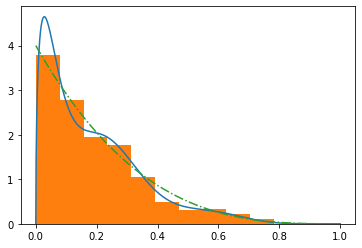

In [65]:
# checking if the posterior density matches the original histogram of Y (WITH 500 ITERATIONS)
plt.plot(np.linspace(0, 1, 1000), pdf_mix_beta(param_mat = [[v*20, (1 - v)*20] for v in full_new['Theta']], 
                      weights = full_new['W'], grid_size = 1000))
plt.hist(Y_new, density = True)
plt.plot(np.linspace(0, 1, 1000), np.array([4*(1 - x)**3 for x in np.linspace(0, 1, 1000)]), '-.')

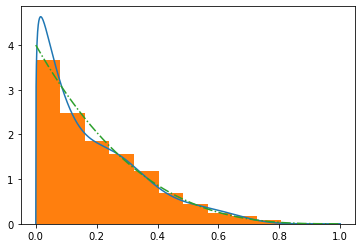

In [21]:
# checking if the posterior density matches the original histogram of Y (WITH 100 ITERATIONS)
plt.plot(np.linspace(0, 1, 1000), pdf_mix_beta(param_mat = [[v*20, (1 - v)*20] for v in full_new['Theta']], 
                      weights = full_new['W'], grid_size = 1000))
plt.hist(Y_new, density = True)
plt.plot(np.linspace(0, 1, 1000), np.array([4*(1 - x)**3 for x in np.linspace(0, 1, 1000)]), '-.')